# Importing necessary libraries and reading the data 

In [242]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [421]:
emails = pd.read_csv('emails.csv')
emails.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [422]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


# Checking Duplicate data and dropping it if it exists

In [423]:
emails.duplicated().sum()

np.int64(33)

In [424]:
emails = emails.drop_duplicates()
emails.duplicated().sum()

np.int64(0)

In [425]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5695 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5695 non-null   object
 1   spam    5695 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 133.5+ KB


In [426]:
emails['text'].str.startswith('Subject:').all()

np.True_

In [427]:
# Remove the 'Subject:' prefix from email text if present
def remove_sub(text):
    msg = text
    return msg.split(':')[1]
emails['text'] = emails['text'].apply(remove_sub)

In [428]:
emails.head()

,text,spam
0,naturally irresistible your corporate identit...,1
1,the stock trading gunslinger fanny is merril...,1
2,unbelievable new homes made easy im wanting ...,1
3,4 color printing special request additional ...,1
4,"do not have money , get software cds from her...",1


# Adding a length column which contains the length of the emails

In [429]:
emails['email_length'] = emails['text'].apply(lambda x : len(x))
emails.head()

,text,spam,email_length
0,naturally irresistible your corporate identit...,1,90
1,the stock trading gunslinger fanny is merril...,1,590
2,unbelievable new homes made easy im wanting ...,1,440
3,4 color printing special request additional ...,1,151
4,"do not have money , get software cds from her...",1,227


In [430]:
emails['email_length'].describe()

count    5695.000000
mean      291.094996
std       525.062313
min         1.000000
25%         4.000000
50%        99.000000
75%       371.000000
max      9244.000000
Name: email_length, dtype: float64

In [431]:
# The text has space or /n that's why its length is 1 
emails[emails['email_length'] == 1]


,text,spam,email_length
906,,1,1


In [432]:
emails[emails['email_length'] == 9244]


,text,spam,email_length
682,"commercialization of nasa technology hey , i...",1,9244


# Some Exploratory Data Analysis

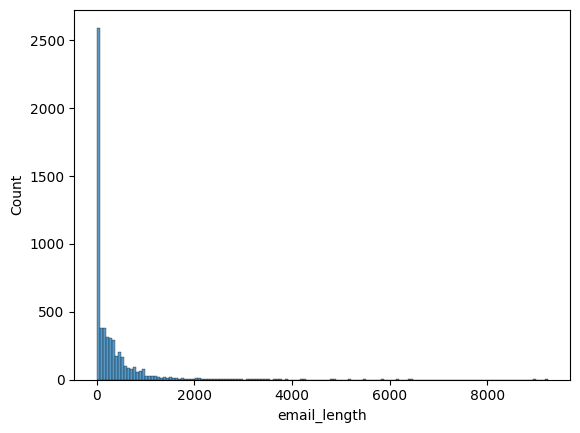

In [433]:
sns.histplot(data=emails , x = 'email_length')
plt.show()

In [434]:
# As seen in the above histplot, there are very few emails whose length is >4000 so removing such emails to improve efficiency
emails = emails[(emails['email_length']<= 4000) & (emails['email_length']>1)]
emails.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5682 entries, 0 to 5727
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          5682 non-null   object
 1   spam          5682 non-null   int64 
 2   email_length  5682 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 177.6+ KB


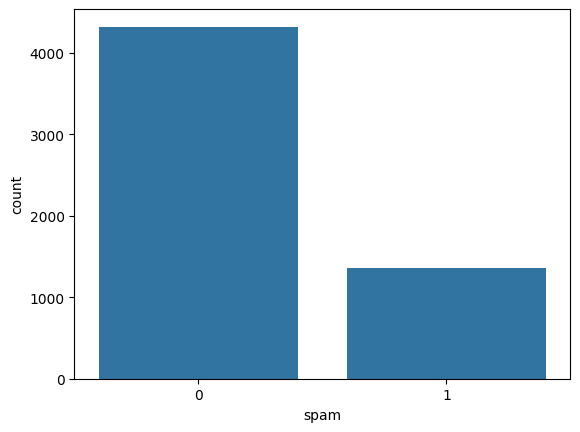

In [435]:
sns.countplot(data = emails , x = 'spam')
plt.show()

# Cleaning the emails by removing punctuation and stopwords

In [436]:
import string
from nltk.corpus import stopwords

In [437]:
stop_words = set(stopwords.words('english'))
def clean_msg(msg):
    no_punc = [c for c in msg if c not in string.punctuation]
    no_punc = ''.join(no_punc)
    return [word for word in no_punc.split() if word.lower() not in stop_words]

In [438]:
emails.head()

,text,spam,email_length
0,naturally irresistible your corporate identit...,1,90
1,the stock trading gunslinger fanny is merril...,1,590
2,unbelievable new homes made easy im wanting ...,1,440
3,4 color printing special request additional ...,1,151
4,"do not have money , get software cds from her...",1,227


# Using CountVectorizer and TF-IDF to convert cleaned text data into numerical feature vectors for machine learning

In [445]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
p = Pipeline([
    ('bow' , CountVectorizer(analyzer=clean_msg)) ,
    ('tfidf' , TfidfTransformer()),
    ('rfc' , RandomForestClassifier(n_estimators= 500))
])

# Training the model

In [446]:
from sklearn.model_selection import train_test_split
X = emails['text']
y = emails['spam']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
print(X_train.shape , y_train.shape , X_test.shape , y_test.shape)

(3977,) (3977,) (1705,) (1705,)


In [447]:
p.fit(X_train , y_train)

,steps,"[('bow', ...), ('tfidf', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [448]:
predictions = p.predict(X_test)

# Evaluating the model

In [449]:
from sklearn.metrics import confusion_matrix, classification_report
print('Confusion matrix :' , confusion_matrix(y_test , predictions))
print('Classification Report : ' , classification_report(y_test , predictions))

Confusion matrix : [[1292   12]
 [  55  346]]
Classification Report :                precision    recall  f1-score   support

           0       0.96      0.99      0.97      1304
           1       0.97      0.86      0.91       401

    accuracy                           0.96      1705
   macro avg       0.96      0.93      0.94      1705
weighted avg       0.96      0.96      0.96      1705



In [450]:
import pickle
with open('spam_classifier_model.pkl', 'wb') as f:
    pickle.dump(p, f)